In [9]:
import pandas as pd
import numpy as np 
from scipy.cluster.vq import *  
import matplotlib.pyplot as plt

In [10]:
fr1 = open('/data/locus/data_16st','r') #打开一个用户的轨迹数据
dict1={} #每隔1小时记录该段时间内经纬度
dict2={} #每隔1小时记录平均经纬度

for line in fr1:    
    item = [k.strip() for k in line.split(',')]       
    index_1h = (int(item[0])-1)/6
    if len(item)<3:
        continue
    if index_1h not in dict1:
        dict1[index_1h] = [[float(item[1]),float(item[2])]]
    else:
        dict1[index_1h].append([float(item[1]),float(item[2])])
for key in dict1:
    list2 = dict1[key]
    dict2[key]=map(np.mean,zip(*list2))   

time_max = max(dict2.keys())#最后一个数据点对应的小时数
data_num = len(dict2)#现有的数组长度

In [11]:
pos_1h = [] #每隔1小时记录的平均位置
pos_1h_x = [] #纬度均值序列 
pos_1h_y = [] #经度均值序列
pos_x = [0]*(time_max+1)
pos_y = [0]*(time_max+1)

for key in dict2:
    pos_1h.append(dict2[key])
    pos_1h_x.append(dict2[key][0])
    pos_1h_y.append(dict2[key][1])
    pos_x[key] = dict2[key][0]
    pos_y[key] = dict2[key][1]
for i in range(time_max+1):
    j = i
    while pos_x[j] == 0:
        j = j+1
    if i == 0:
        for k in range(i,j):
            pos_x[k] = pos_x[j]
            pos_y[k] = pos_y[j]
    else:
        for k in range(i,j):
            pos_x[k] = ((j-k)*pos_x[i-1] + (k-i+1)*pos_x[j])/(j-i+1)
            pos_y[k] = ((j-k)*pos_y[i-1] + (k-i+1)*pos_y[j])/(j-i+1)

In [12]:
S = []
L = 168
pos_x1 = [] #纬度预测序列
alpha = 0.05 #Holt-winters算法参数
beta = 0.01
gamma = 0.005
A1 = np.mean (pos_x[0:L])
A2 = np.mean (pos_x[L:2*L])
b = (A2-A1)/L
a = A1 + (L-1)*b/2
for i in range(L):
    S.append( pos_x[i]/(a-(L-1-i)*b) )
for i in range(L*2):
    pos_x1.append(pos_x[i])

A = []
B = []
A.append(a)
B.append(b)
for j in range(len(pos_x)-L):
    t = int(j/L)*L
    if t>0:
        y_infer = (A[t]+B[t]*((j+1)%L))*S[j]
        pos_x1.append (y_infer)
    A.append (alpha*pos_x1[j+L]/S[j] + (1-alpha)*(A[j]+B[j]))
    B.append (beta*(A[j+1]-A[j]) + (1-beta)*B[j])
    S.append (gamma*pos_x1[j+L]/A[j+1] + (1-gamma)*S[j])

In [13]:
S = []
pos_y1 = [] #经度预测序列
A1 = np.mean (pos_y[0:L])
A2 = np.mean (pos_y[L:2*L])
b = (A2-A1)/L
a = A1 + (L-1)*b/2
for i in range(L):
    S.append( pos_y[i]/(a-(L-1-i)*b) )
for i in range(L*2):
    pos_y1.append(pos_y[i])

A = []
B = []
A.append(a)
B.append(b)
for j in range(len(pos_y)-L):
    t = int(j/L)*L
    if t>0:
        y_infer = (A[t]+B[t]*((j+1)%L))*S[j]
        pos_y1.append (y_infer)
    A.append (alpha*pos_y1[j+L]/S[j] + (1-alpha)*(A[j]+B[j]))
    B.append (beta*(A[j+1]-A[j]) + (1-beta)*B[j])
    S.append (gamma*pos_y1[j+L]/A[j+1] + (1-gamma)*S[j])

In [14]:
X = pd.DataFrame({"lon":pos_x[0:2*L],"lat":pos_y[0:2*L]})
pos_1 = np.array(X)
res, idx = kmeans2(pos_1, 3, iter=20, minit='points')

def distance(x1,y1,x2,y2):#x纬度，y经度，计算两点间大致距离
    return np.sqrt( 11.1*np.square(x2-x1)+8.5*np.square(y2-y1))

y_predict = []
y_real = []
for i in range(2*L,time_max+1):
    dis1 = distance(pos_x1[i],pos_y1[i],res[0][1],res[0][0])
    dis2 = distance(pos_x1[i],pos_y1[i],res[1][1],res[1][0])
    dis3 = distance(pos_x1[i],pos_y1[i],res[2][1],res[2][0])
    dis_min = min(dis1,dis2,dis3)
    if dis1 == dis_min:
        y_predict.append(1)
    elif dis2 == dis_min:
        y_predict.append(2)
    else:
        y_predict.append(3)
    disx1 = distance(pos_x[i],pos_y[i],res[0][1],res[0][0])
    disx2 = distance(pos_x[i],pos_y[i],res[1][1],res[1][0])
    disx3 = distance(pos_x[i],pos_y[i],res[2][1],res[2][0])
    disx_min = min(disx1,disx2,disx3)
    if disx1 == disx_min:
        y_real.append(1)
    elif disx2 == disx_min:
        y_real.append(2)
    else:
        y_real.append(3)
        
err = 0
for i in range(len(y_real)):
    if y_real[i]!=y_predict[i]:
        err = err+1
Acc_rate = float('%.2f' %(100*(1 - float(err)/len(y_real))) )
print str(Acc_rate)+'%' #预测的准确率 

83.82%


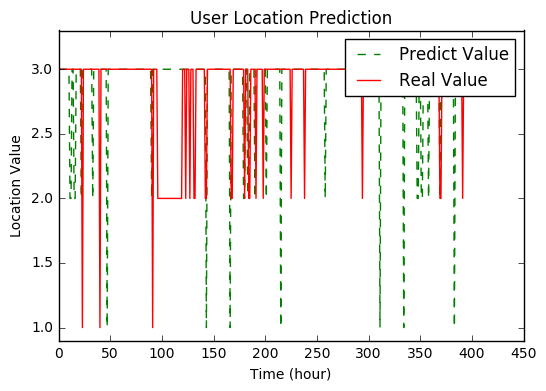

In [15]:
x = range(len(y_real))
fig, ax = plt.subplots()
plot1, = plt.plot(x, y_predict, 'g--',label="Predict Value",linewidth=1)
plot2, = plt.plot(x, y_real, 'r',label="Real Value",linewidth=1)
plt.title('User Location Prediction')
plt.xlabel('Time (hour)')
plt.ylabel('Location Value')
plt.ylim(0.9,3.3)
plt.legend([plot1,plot2],['Predict Value','Real Value'])
plt.show()